# Entrainer un réseau en le modifiant pour une tâche spécifique

## Utiliser notre jeu de données dans PyTorch

Tout se fait très rapidement avec la classe `ImageFolder`.

Example input:


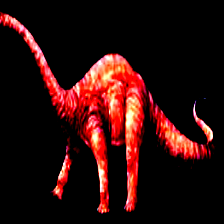

Example target: 0


In [1]:
from multiprocessing import cpu_count
from os.path import join
from tempfile import NamedTemporaryFile

from IPython.core.display import Image, display
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.utils import save_image

BATCH_SIZE = 8
NUM_WORKERS = cpu_count()

# Data loading code
traindir = join("pics", "train")
valdir = join("pics", "val")

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_dataset = ImageFolder(traindir, transforms.Compose([
    transforms.Resize((256, 256)),
    # Get some data for free
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
]))
eval_dataset = ImageFolder(valdir, transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    normalize,
]))

train_dataloader = DataLoader(
    train_dataset, batch_size = BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS)
eval_dataloader = DataLoader(
    eval_dataset, batch_size = BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS)

with NamedTemporaryFile(suffix=".png") as fh:
    save_image(train_dataset[0][0], fh.name)
    print("Example input:")
    display(Image(fh.name))
print("Example target: %d" % train_dataset[0][1])

## Récupérer un modèle et l'adapter

PyTorch dispose de quelques modèles pré-entrainés sur Imagenet qui sont très utiles pour faire de petites applis pour traiter des images. On va voir ici comment les adaptés à une tâche différente de celle sur laquelle ils ont été entrainés.

In [2]:
from torch.nn import Linear
from torchvision.models import resnet50

model = resnet50(pretrained=True)
for child in model.children():
    for param in child.parameters():
        param.requires_grad = False

print("Couche finale, avant : %s" % model.fc)

model.fc = Linear(in_features=2048, out_features=2, bias=True)

print("Couche finale, après : %s" % model.fc)

Couche finale, avant : Linear(in_features=2048, out_features=1000, bias=True)
Couche finale, après : Linear(in_features=2048, out_features=2, bias=True)


## Fonction de perte et optimisation des poids

On définit une fonction de perte (pour savoir si nos prédictions sont bonnes ou non) et un optimisateur qui va décider comment changer les poids de notre réseau en fonction de l'erreur commise pour des exemples donnés.

In [3]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

criterion = CrossEntropyLoss()

optimizer = Adam(model.parameters())

## Entrainement

On peut maintenant entrainer notre réseau \o/

In [4]:
import torch
from tqdm import tqdm

for epoch in range(1, 11):
    print("***")
    print("Training on complete training data", flush=True)
    model.train()
    for image, label in tqdm(train_dataloader):
        output = model.forward(image)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Evaluating on complete evaluation data", flush=True)
    total_correct = 0
    total = 0
    model.eval()
    for image, label in tqdm(eval_dataloader):
        output = model.forward(image)
        total_correct += (output.argmax(dim=1) == label).sum().item()
        total += output.size(0)
    print("Accuraccy at epoch %d: %.2f" % (epoch, total_correct / total), flush=True)
torch.save(model.state_dict(), "model.pth")

***
Training on complete training data


100%|██████████| 11/11 [00:14<00:00,  1.11s/it]

Evaluating on complete evaluation data



100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

Accuraccy at epoch 1: 0.75
***
Training on complete training data



100%|██████████| 11/11 [00:16<00:00,  1.22s/it]

Evaluating on complete evaluation data



100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

Accuraccy at epoch 2: 0.95
***
Training on complete training data



100%|██████████| 11/11 [00:17<00:00,  1.25s/it]

Evaluating on complete evaluation data



100%|██████████| 3/3 [00:03<00:00,  1.36s/it]

Accuraccy at epoch 3: 0.95
***
Training on complete training data



100%|██████████| 11/11 [00:15<00:00,  1.18s/it]

Evaluating on complete evaluation data



100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

Accuraccy at epoch 4: 0.85
***
Training on complete training data



100%|██████████| 11/11 [00:16<00:00,  1.19s/it]

Evaluating on complete evaluation data



100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

Accuraccy at epoch 5: 0.75
***
Training on complete training data



100%|██████████| 11/11 [00:15<00:00,  1.18s/it]

Evaluating on complete evaluation data



100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

Accuraccy at epoch 6: 0.95
***
Training on complete training data



100%|██████████| 11/11 [00:16<00:00,  1.29s/it]

Evaluating on complete evaluation data



100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

Accuraccy at epoch 7: 1.00
***
Training on complete training data



100%|██████████| 11/11 [00:16<00:00,  1.21s/it]

Evaluating on complete evaluation data



100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

Accuraccy at epoch 8: 1.00
***
Training on complete training data



100%|██████████| 11/11 [00:15<00:00,  1.18s/it]

Evaluating on complete evaluation data



100%|██████████| 3/3 [00:03<00:00,  1.36s/it]

Accuraccy at epoch 9: 1.00
***
Training on complete training data



100%|██████████| 11/11 [00:16<00:00,  1.23s/it]

Evaluating on complete evaluation data



100%|██████████| 3/3 [00:03<00:00,  1.36s/it]

Accuraccy at epoch 10: 1.00
